In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

load_names = np.array(["Fridge","Electrical Cooktop","Oven","Modem","Dryer","TV", "AC", "Washer", "Dishwasher", "Lights"])

# Nominal power (kW)
P_rated = np.array([0.2,7.0,4.0,0.01,4.0,0.15,2.5,2.2,2.4,0.5])  # kW

##Total 22.96kW


In [3]:
# 1 = Highest priority
# 1 = High , 2 = Mean, 3 = Low
priority = np.array([1, 2, 2, 1, 3, 3, 2, 3, 3, 1])

In [4]:
hours = np.arange(24)  # 0,1,...,23

use_fridge = np.ones(24)

use_cooktop = np.zeros(24)
use_cooktop[7]  = 1
use_cooktop[13] = 1
use_cooktop[19] = 1


use_oven = np.zeros(24)
use_oven[18] = 1


use_modem = np.ones(24)


use_dryer = np.zeros(24)
use_dryer[15] = 1


use_tv = np.zeros(24)
use_tv[20:24] = 1   # 20,21,22,23


use_ac = np.zeros(24)
use_ac[18:24] = 1   # 18,19,20,21,22,23


use_washer = np.zeros(24)
use_washer[14] = 1


use_dishwasher = np.zeros(24)
use_dishwasher[22] = 1


use_lights = np.zeros(24)
use_lights[18:24] = 1   #18,19,20,21,22,23


usages_winter = np.vstack([
    use_fridge,       # "Fridge"
    use_cooktop,      # "Electrical Cooktop"
    use_oven,         # "Oven"
    use_modem,        # "Modem"
    use_dryer,        # "Dryer"
    use_tv,           # "TV"
    use_ac,           # "AC"
    use_washer,       # "Washer"
    use_dishwasher,   # "Dishwasher"
    use_lights        # "Lights"
])


In [5]:
# P_rated: (5,)
# usages_winter: (5, 24)

P_total_winter = (P_rated[:, None] * usages_winter).sum(axis=0)

hour_20_power = P_total_winter[20]
print("Total power at that hour (kW):", hour_20_power)


Total power at that hour (kW): 3.36


In [6]:
P_total_winter = np.zeros(24)  

for t in range(24):  # 0,1,2,...,23
    total_power_at_t = 0.0
    for i in range(len(load_names)):  
        total_power_at_t += P_rated[i] * usages_winter[i, t]
    P_total_winter[t] = total_power_at_t

print(total_power_at_t)
print(P_total_winter)

3.36
[ 0.21  0.21  0.21  0.21  0.21  0.21  0.21  7.21  0.21  0.21  0.21  0.21
  0.21  7.21  2.41  4.21  0.21  0.21  7.21 10.21  3.36  3.36  5.76  3.36]


In [7]:

daily_energy_kWh = P_total_winter.sum()
print("Total energy for a day:", daily_energy_kWh, "kWh")



Total energy for a day: 57.24 kWh


In [8]:
#PV Panel Energy Generate (Maxeon3 SPR-MAX3-430) (Rotterdam)
#One single panel generates 0.43 , in this house we used 5 Panels. So Pv nominal power will be equal to 2.15kwH
#PV_nominal_power= float(0.43)    #optimum standarts are accepted in this situation (in kW)

def get_pv_profile_for_month(month_name: str, PV_nominal_power: float = 2.15) -> np.ndarray:

    monthly_sun_hours = {
        "June": 280,
        "July": 305,
        "August": 270
    }

    
    days_in_month = {
        "June": 30,
        "July": 31,
        "August": 31
    }

    
    month_key = month_name.capitalize()

    sun_hours_total = monthly_sun_hours[month_key]
    days = days_in_month[month_key]

    
    sun_hours_per_day = sun_hours_total / days    
    sun_hours_rounded = int(round(sun_hours_per_day))  

    
    P_pv = np.zeros(24)
    hours = np.arange(24)

    
    start_hour = 10
    end_hour = min(start_hour + sun_hours_rounded, 24)

    
    P_pv[start_hour:end_hour] = PV_nominal_power

    return P_pv





In [9]:
import numpy as np

def apply_load_shifting(usages,
                        P_rated,
                        priority,
                        threshold,
                        peak_start=17,
                        peak_end=22,
                        max_iterations=2000):

    
    usages_shifted = usages.copy()
    P_total_before = (P_rated[:, None] * usages_shifted).sum(axis=0)
    P_total = P_total_before.copy()
    
    
    non_peak_hours = [h for h in range(24) if not (peak_start <= h <= peak_end)]
    
    N, T = usages_shifted.shape
    iteration = 0
    
    for t in range(peak_start, peak_end + 1):
        
        while P_total[t] > threshold and iteration < max_iterations:
            iteration += 1
            
            running = np.where(usages_shifted[:, t] > 0)[0]
            if len(running) == 0:
                break  
            
            
            for prio_level in [3, 2]:
                shiftable_mask = (priority[running] == prio_level)
                shiftable = running[shiftable_mask]
                
                if len(shiftable) == 0:
                    continue  
                
                
                loads_power = P_rated[shiftable]
                worst_idx = shiftable[np.argmax(loads_power)]
                
                
                sorted_non_peak = sorted(non_peak_hours, key=lambda h: P_total[h])
                
                moved = False
                for new_t in sorted_non_peak:
                    if usages_shifted[worst_idx, new_t] == 0:
                        
                        usages_shifted[worst_idx, t] = 0
                        usages_shifted[worst_idx, new_t] = 1
                        
                        
                        P_total = (P_rated[:, None] * usages_shifted).sum(axis=0)
                        
                        moved = True
                        break  
                
                if moved:
                    break  
            
            else:
                
                
                break
    
    P_total_after = P_total.copy()
    return usages_shifted, P_total_before, P_total_after


usages_winter_shifted, P_total_winter_before, P_total_winter_after = apply_load_shifting(
    usages=usages_winter,
    P_rated=P_rated,
    priority=priority,
    threshold=6.0,        
    peak_start=17,
    peak_end=22
)

print("Before loadshift:", P_total_winter_before)
print("After loadshift   :", P_total_winter_after)
print("New Usage Matrice:\n", usages_winter_shifted)


Before loadshift: [ 0.21  0.21  0.21  0.21  0.21  0.21  0.21  7.21  0.21  0.21  0.21  0.21
  0.21  7.21  2.41  4.21  0.21  0.21  7.21 10.21  3.36  3.36  5.76  3.36]
After loadshift   : [4.21 7.21 0.21 0.21 0.21 0.21 0.21 7.21 0.21 0.21 0.21 0.21 0.21 7.21
 2.41 4.21 0.21 0.21 3.21 3.21 3.36 3.36 5.76 3.36]
New Usage Matrice:
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0

In [10]:

selected_month = "July"   
P_pv = get_pv_profile_for_month(selected_month)


# Maximum load of the home is 10.21kWH at 19:00
# Battery Capacity is 5,105kwH
# 1,021kW maximum charging capacity
# 1,53 maximum discharging capacity

E_batt = 5.105   # kWh 




T = 24  
peak_start= 17
peak_end= 22

P_grid = np.zeros(T)           
SoC = np.zeros(T)              
P_batt_charge = np.zeros(T)    
P_batt_discharge = np.zeros(T) 


P_charge_max = 0.2 * E_batt      
P_discharge_max = 0.3 * E_batt   

SoC_current = 0.10 * E_batt      
SoC_min = 0.30 * E_batt          
SoC_restart = 0.50 * E_batt      
SoC_max = 0.80 * E_batt          


allowed_to_discharge = SoC_current >= SoC_restart

for t in range(T):
    
    load = P_total_winter_after[t]
    pv   = P_pv[t]

    
    P_from_pv = min(load, pv)
    residual = load - P_from_pv    
    surplus_pv = pv - P_from_pv    

    # Discharge from battery at peak hours
    if peak_start <= t <= peak_end and residual > 0 and allowed_to_discharge:
        
        available_energy = max(SoC_current - SoC_min, 0.0)

        
        max_discharge_power = min(P_discharge_max, available_energy)

        
        P_from_batt = min(residual, max_discharge_power)

        if P_from_batt > 0:
            residual -= P_from_batt
            SoC_current -= P_from_batt     
            P_batt_discharge[t] = P_from_batt

        
        if SoC_current <= SoC_min + 1e-9:
            allowed_to_discharge = False

    
    if surplus_pv > 0 and SoC_current < SoC_max:
        
        max_charge_energy = SoC_max - SoC_current

        
        P_to_batt = min(surplus_pv, P_charge_max, max_charge_energy)

        SoC_current += P_to_batt
        P_batt_charge[t] = P_to_batt
        

    # If SoC over 50% start discharging
    if SoC_current >= SoC_restart:
        allowed_to_discharge = True

    
    P_grid[t] = max(residual, 0.0)

    # At the end of hour save the SoC 
    SoC[t] = SoC_current

# Results
print("Selected Month: ", selected_month)
print("P_grid (kW):", P_grid)
print("SoC (kWh):", SoC)
print("Total daily grid energy (kWh):", P_grid.sum())






Selected Month:  July
P_grid (kW): [4.21   7.21   0.21   0.21   0.21   0.21   0.21   7.21   0.21   0.21
 0.     0.     0.     5.06   0.26   2.06   0.     0.     0.     0.
 2.9275 3.36   5.76   3.36  ]
SoC (kWh): [0.5105 0.5105 0.5105 0.5105 0.5105 0.5105 0.5105 0.5105 0.5105 0.5105
 1.5315 2.5525 3.5735 3.5735 3.5735 3.5735 4.084  4.084  3.024  1.964
 1.5315 1.5315 1.5315 1.5315]
Total daily grid energy (kWh): 42.887499999999996


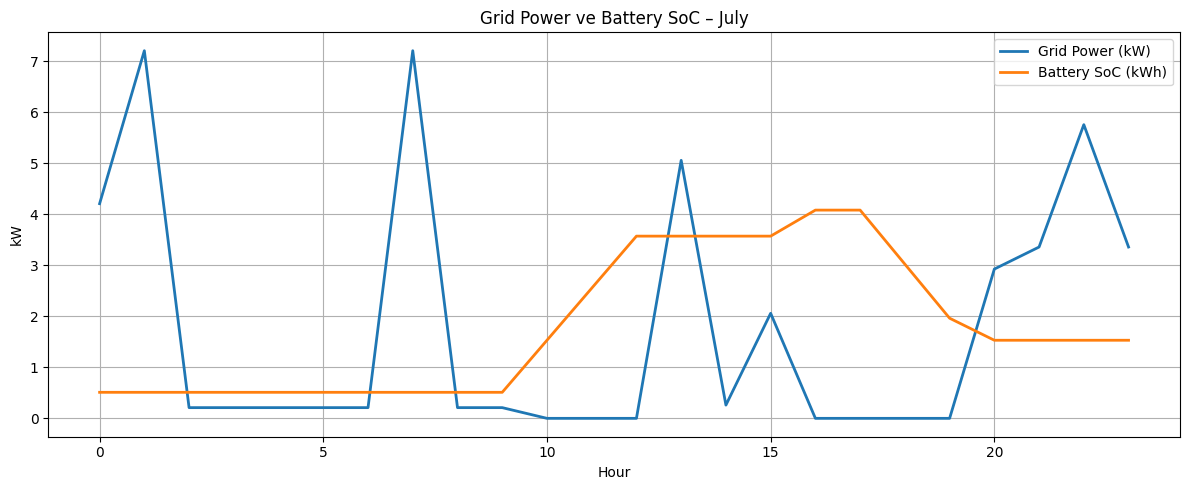

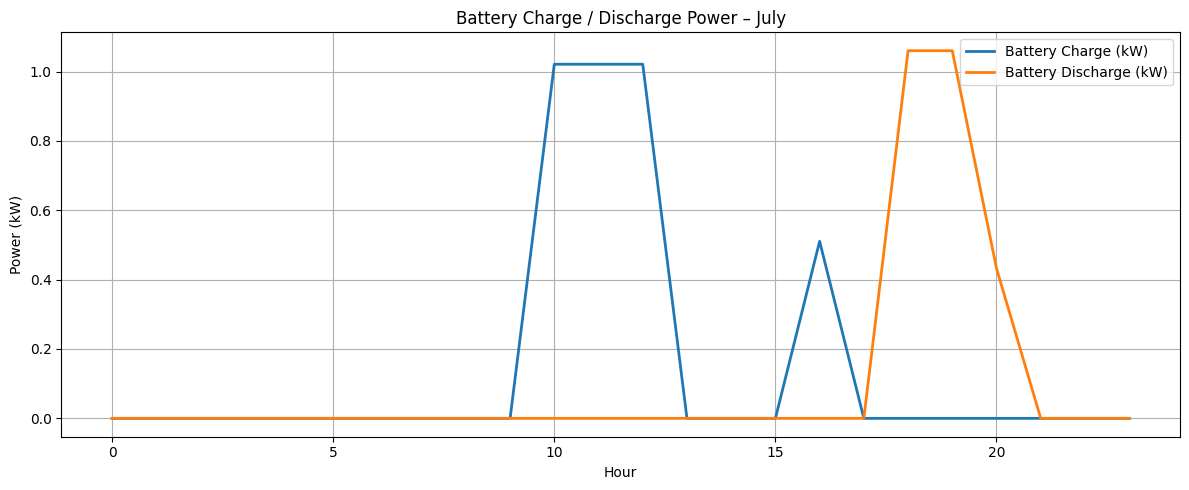

In [11]:
hours = np.arange(24)

#Grid and Battery SoC
plt.figure(figsize=(12,5))
plt.plot(hours, P_grid, label="Grid Power (kW)", linewidth=2)
plt.plot(hours, SoC,    label="Battery SoC (kWh)", linewidth=2)
plt.title("Grid Power ve Battery SoC – July")
plt.xlabel("Hour")
plt.ylabel("kW")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Battery charge discharge
plt.figure(figsize=(12,5))
plt.plot(hours, P_batt_charge,    label="Battery Charge (kW)", linewidth=2)
plt.plot(hours, P_batt_discharge, label="Battery Discharge (kW)", linewidth=2)
plt.title("Battery Charge / Discharge Power – July")
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

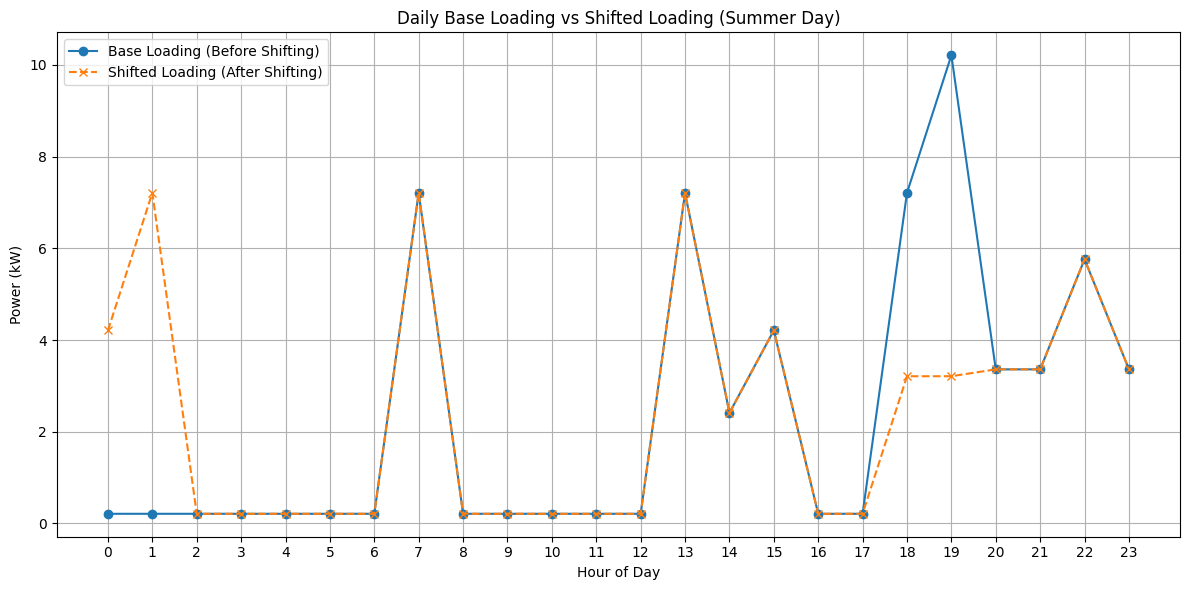

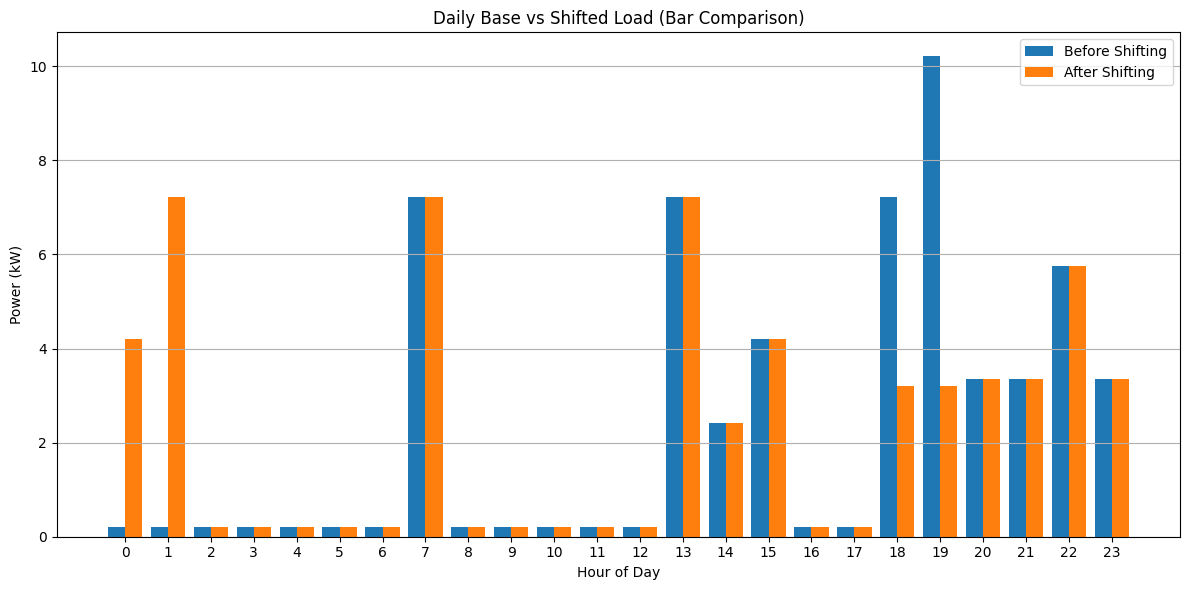

In [12]:

import matplotlib.pyplot as plt



hours = np.arange(24)


# 1) Line graph 


plt.figure(figsize=(12, 6))

plt.plot(hours, P_total_winter_before, marker='o', linestyle='-', label='Base Loading (Before Shifting)')
plt.plot(hours, P_total_winter_after, marker='x', linestyle='--', label='Shifted Loading (After Shifting)')

plt.xticks(hours)
plt.xlabel("Hour of Day")
plt.ylabel("Power (kW)")
plt.title("Daily Base Loading vs Shifted Loading (Summer Day)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# 2) Bar Graph


plt.figure(figsize=(12, 6))
bar_width = 0.4

plt.bar(hours - bar_width/2, P_total_winter_before, width=bar_width, label='Before Shifting')
plt.bar(hours + bar_width/2, P_total_winter_after,  width=bar_width, label='After Shifting')

plt.xticks(hours)
plt.xlabel("Hour of Day")
plt.ylabel("Power (kW)")
plt.title("Daily Base vs Shifted Load (Bar Comparison)")
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
#Triple time tariff process

hours = np.arange(24)

night_price = 2.21   
day_price   = 3.49   
peak_price  = 5.09   

prices = np.zeros(24)

# Night: 23:00 – 05:00
night_hours = [23] + list(range(0, 6))  # 23, 0, 1, 2, 3, 4, 5

# Day: 06:00 – 16:00
day_hours   = list(range(6, 17))        # 6–16

# Puant: 17:00 – 22:00
peak_hours  = list(range(17, 23))       # 17–22


prices[night_hours] = night_price
prices[day_hours]   = day_price
prices[peak_hours]  = peak_price


energy_before = P_total_winter_before * 1.0  # kWh
energy_after  = P_total_winter_after  * 1.0  # kWh

# Hourly prices
cost_before_hourly = energy_before * prices
cost_after_hourly  = energy_after  * prices

# Daily total costs
daily_cost_before = cost_before_hourly.sum()
daily_cost_after  = cost_after_hourly.sum()

# Results
print("=== Triple-Time Tariff Cost Comparison ===")
print("Night price  (TL/kWh):", night_price)
print("Day price    (TL/kWh):", day_price)
print("Peak price   (TL/kWh):", peak_price)
print()

print("Daily energy (before shifting): {:.2f} kWh".format(energy_before.sum()))
print("Daily energy (after  shifting): {:.2f} kWh".format(energy_after.sum()))
print()

print("Daily cost   (before shifting): {:.2f} TL".format(daily_cost_before))
print("Daily cost   (after  shifting): {:.2f} TL".format(daily_cost_after))
print("Cost difference (before - after): {:.2f} TL".format(daily_cost_before - daily_cost_after))

if daily_cost_before > 0:
    saving_percent = (daily_cost_before - daily_cost_after) / daily_cost_before * 100
    print("Relative saving with load shifting: {:.2f} %".format(saving_percent))


=== Triple-Time Tariff Cost Comparison ===
Night price  (TL/kWh): 2.21
Day price    (TL/kWh): 3.49
Peak price   (TL/kWh): 5.09

Daily energy (before shifting): 57.24 kWh
Daily energy (after  shifting): 57.24 kWh

Daily cost   (before shifting): 242.03 TL
Daily cost   (after  shifting): 210.35 TL
Cost difference (before - after): 31.68 TL
Relative saving with load shifting: 13.09 %
